In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch.utils.data as Data

In [3]:
import pandas_profiling as ppf
data = pd.read_csv('train_data.csv')
# ppf.ProfileReport(data)

In [4]:


# 分割训练集和测试集
x = data.iloc[:, [0,2]].values
y = data.iloc[:, 1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 数据标准化
ss1 = preprocessing.StandardScaler()
x_train = ss1.fit_transform(x_train)
x_test = ss1.transform(x_test)
x_total=ss1.transform(x)


y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train-y_mean)/y_std
y_test=(y_test-y_mean)/y_std

# numpy转tensor
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float().view(-1,1)
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float().view(-1,1)
x_total=torch.from_numpy(x_total).float()

# batch_size = 64
torch_dataset = Data.TensorDataset(x_train, y_train) 
loader = Data.DataLoader(dataset=torch_dataset,batch_size=16,
            shuffle=True) 

# print(next(iter(loader)))

x_train


tensor([[-1.1330,  0.7382],
        [-0.4298,  0.3182],
        [ 0.6466, -1.3619],
        [ 0.5165,  0.7382],
        [-0.4920,  0.3182],
        [ 0.4015, -1.3619],
        [-0.7899,  0.3182],
        [-1.1971,  0.7382],
        [ 0.2074, -1.3619],
        [-0.5241,  0.3182],
        [-1.8550,  1.1582],
        [ 1.7287, -1.3619],
        [ 0.1018,  0.3182],
        [-0.9388,  1.1582],
        [ 0.0924, -1.3619],
        [-0.5655,  0.7382],
        [ 1.2894, -1.3619],
        [ 0.4468,  0.3182],
        [-1.9323,  1.1582],
        [-0.6956,  0.3182],
        [-0.0226,  0.3182],
        [ 0.9803, -1.3619],
        [-0.7069,  0.7382],
        [ 1.3799, -1.3619],
        [ 0.0924, -1.3619],
        [ 0.6183,  0.3182],
        [-1.2367,  0.7382],
        [ 1.3026, -1.3619],
        [ 0.1188,  0.3182],
        [-1.3385,  1.1582],
        [-1.5703,  1.1582],
        [ 0.3205,  0.3182],
        [ 0.0924,  0.7382],
        [ 1.7664, -1.3619],
        [-1.0293,  1.1582],
        [ 1.9097, -1

In [5]:
class LR(nn.Module):

    def __init__(self):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
import torch.optim.lr_scheduler as lr_scheduler
# 模型初始化
net = LR()
criterion = nn.MSELoss()
optm = torch.optim.Adam(net.parameters(), lr=0.001,weight_decay=0.01)
scheduler = lr_scheduler.MultiStepLR(optm, milestones=[100,500,1000,1500], gamma=0.1)

epochs = 2000


In [7]:
epochs_list=[]
train_loss_list=[]
test_error_list=[]
for e in range(epochs):
    epochs_list.append(e)
    for i, (batch_x, batch_y) in enumerate(loader):
        y_hat = net(batch_x)
#         print(y_hat.shape)
        
        loss = criterion(y_hat, batch_y)
        optm.zero_grad()
        loss.backward()
        optm.step()
    
    y_pred_train= net(x_train)
    loss = criterion(y_pred_train, y_train)
    train_loss_list.append(loss.item())
    
    net.eval()
    y_pred_test = net(x_test)
    error = criterion(y_pred_test, y_test)
    test_error_list.append(error.item())
    if (e+1)%50==0:
        print("Epoch:{}, trainLoss:{}，testLoss:{}".format(e+1,loss.item(),error.item()))
    

Epoch:50, trainLoss:0.21323858201503754，testLoss:0.2957354187965393
Epoch:100, trainLoss:0.1481904685497284，testLoss:0.28941744565963745
Epoch:150, trainLoss:0.11545807868242264，testLoss:0.2611435651779175
Epoch:200, trainLoss:0.10195166617631912，testLoss:0.2571793794631958
Epoch:250, trainLoss:0.08460894972085953，testLoss:0.24383392930030823
Epoch:300, trainLoss:0.07945438474416733，testLoss:0.24925699830055237
Epoch:350, trainLoss:0.07723801583051682，testLoss:0.235481858253479
Epoch:400, trainLoss:0.07468324154615402，testLoss:0.24519802629947662
Epoch:450, trainLoss:0.06819891184568405，testLoss:0.2235872596502304
Epoch:500, trainLoss:0.06564706563949585，testLoss:0.23546263575553894
Epoch:550, trainLoss:0.07054958492517471，testLoss:0.2562001645565033
Epoch:600, trainLoss:0.06395106017589569，testLoss:0.22205114364624023
Epoch:650, trainLoss:0.06104646995663643，testLoss:0.22973334789276123
Epoch:700, trainLoss:0.0632961094379425，testLoss:0.22391802072525024
Epoch:750, trainLoss:0.0622602

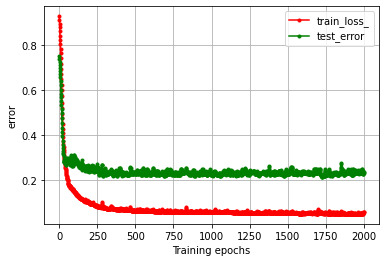

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Training epochs")
plt.ylabel("error")
plt.grid()
plt.plot(epochs_list, train_loss_list, '.-', color="r",
                label="train_loss_")
plt.plot(epochs_list, test_error_list, '.-', color="g",
                label="test_error")

plt.legend(loc="best")


In [9]:
valid_data=pd.read_csv('test_data.csv').values
valid_data_target=valid_data[:,[0,2]]
valid_data_y=valid_data[:,1]
valid_data_y

array([-12.41027374, -12.42054339, -10.58527999, -10.40483445,
       -10.22438893, -10.21411966, -10.10409191, -10.10409191,
        -9.99259711,  -9.92217934,  -9.81215158,  -9.62143679,
        -9.61116754,  -9.61116754,  -9.50113978,  -9.31042499,
        -9.270815  ,  -9.20039723,  -9.09036947,  -8.99941318,
        -8.88938543,  -8.8086984 ,  -8.67959916,  -8.48888437,
        -8.52849437,  -8.31724107])

(-13.0, -7.0)

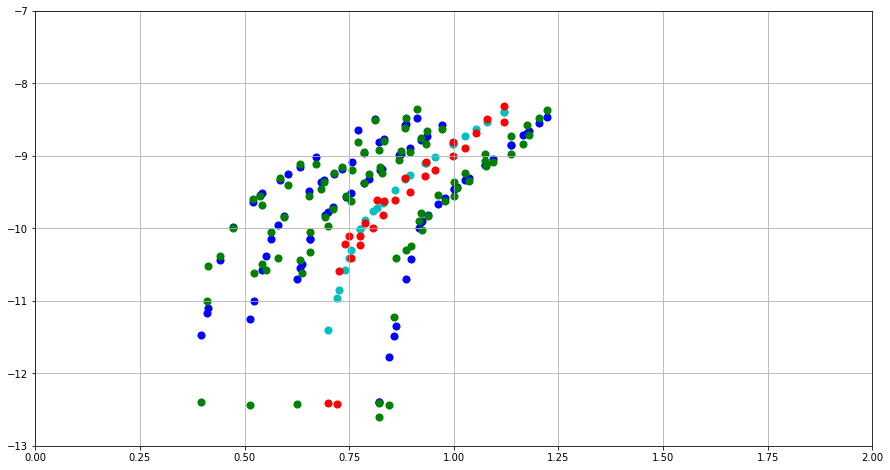

In [10]:
net.eval()
x_valid=ss1.transform(valid_data_target)
x_valid = torch.from_numpy(x_valid).float()

y_pred=net(x_total)
y_pred=y_pred.data.numpy()
y_pred=y_pred*y_std+y_mean

y_pred_valid=net(x_valid)
y_pred_valid=y_pred_valid.data.numpy()
y_pred_valid=y_pred_valid*y_std+y_mean

x_axis=data.iloc[:,0].values

plt.figure(figsize=(15,8))
plt.scatter(x_axis,y_pred,s=50,c="b")
plt.scatter(x_axis,y,s=50,c="g")

x_axis_valid=valid_data[:,0]
plt.scatter(x_axis_valid,y_pred_valid,s=50,c="c")
plt.scatter(x_axis_valid,valid_data_y,s=50,c="r")
plt.grid()
plt.xlim(0,2)
plt.ylim(-13,-7)